# Random Forests

## Learning Objectives
By the end of this notebook, you will be able to:
- Understand the concept of ensemble learning
- Explain how Random Forests combine multiple decision trees
- Understand bootstrap aggregating (bagging)
- Apply Random Forests to classification problems
- Compare single trees vs Random Forests
- Tune Random Forest hyperparameters
- Understand out-of-bag (OOB) error

## Introduction

**The Wisdom of Crowds**: Imagine asking one person to estimate the number of jelly beans in a jar. Their guess might be way off. But if you ask 100 people and take the average, the result is surprisingly accurate!

**Random Forests** apply the same principle to machine learning:
- Train many decision trees (the "crowd")
- Each tree gets a slightly different view of the data
- Combine their predictions (voting or averaging)
- Result: More accurate and stable than any single tree!

## Setup

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer, make_classification
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. The Problem with Single Decision Trees

Let's first see why we need Random Forests by examining the instability of single trees.

Dataset: 200 samples, 2 features
Classes: [0 1]


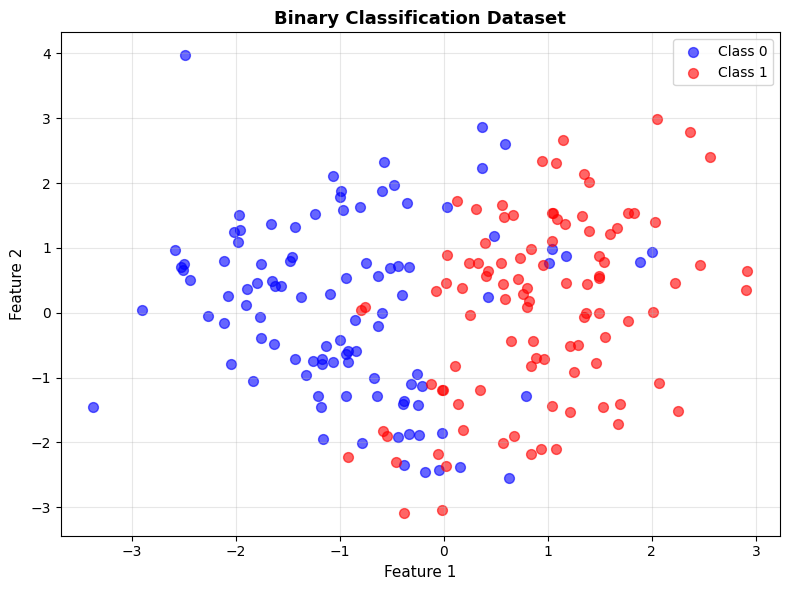

In [2]:
# Create a simple dataset
X, y = make_classification(
    n_samples=200,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_classes=2,
    random_state=42
)

print(f"Dataset: {X.shape[0]} samples, {X.shape[1]} features")
print(f"Classes: {np.unique(y)}")

# Visualize
plt.figure(figsize=(8, 6))
plt.scatter(X[y==0, 0], X[y==0, 1], c='blue', label='Class 0', alpha=0.6, s=50)
plt.scatter(X[y==1, 0], X[y==1, 1], c='red', label='Class 1', alpha=0.6, s=50)
plt.xlabel('Feature 1', fontsize=11)
plt.ylabel('Feature 2', fontsize=11)
plt.title('Binary Classification Dataset', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Training the same tree with different train/test splits:

Trial  1: Test Accuracy = 0.800
Trial  2: Test Accuracy = 0.817
Trial  3: Test Accuracy = 0.867
Trial  4: Test Accuracy = 0.850
Trial  5: Test Accuracy = 0.800
Trial  6: Test Accuracy = 0.833
Trial  7: Test Accuracy = 0.867
Trial  8: Test Accuracy = 0.867
Trial  9: Test Accuracy = 0.867
Trial 10: Test Accuracy = 0.783

Mean Accuracy: 0.835 ± 0.031
Range: [0.783, 0.867]
Variability: 8.3 percentage points


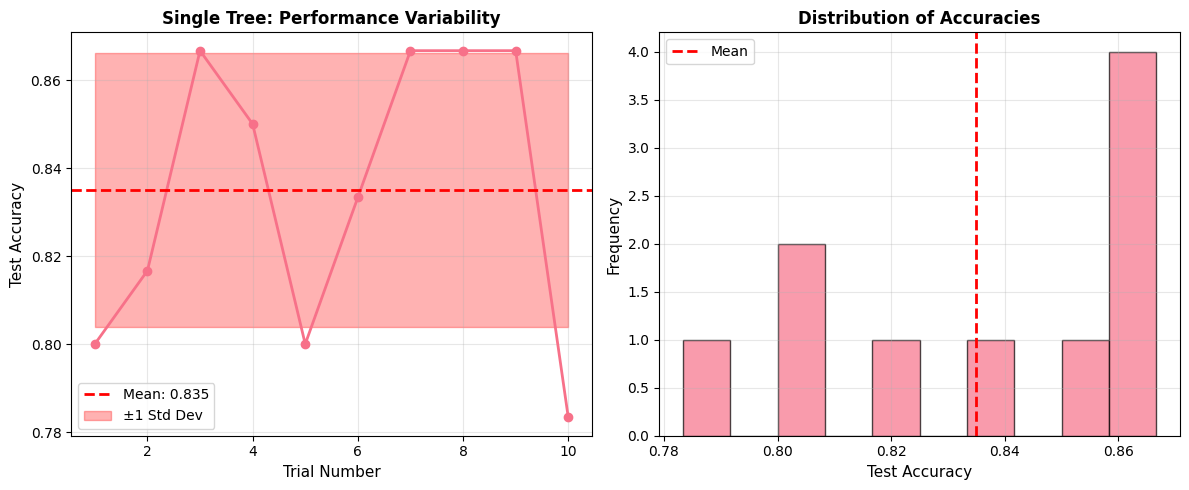


Problem: Single trees are UNSTABLE!
Solution: Use MANY trees and combine their predictions!


In [3]:
# Train same tree with different random splits
n_trials = 10
tree_scores = []

print("Training the same tree with different train/test splits:\n")
for i in range(n_trials):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=i
    )
    
    tree = DecisionTreeClassifier(max_depth=5, random_state=42)
    tree.fit(X_train, y_train)
    score = tree.score(X_test, y_test)
    tree_scores.append(score)
    print(f"Trial {i+1:2d}: Test Accuracy = {score:.3f}")

tree_scores = np.array(tree_scores)
print(f"\nMean Accuracy: {tree_scores.mean():.3f} ± {tree_scores.std():.3f}")
print(f"Range: [{tree_scores.min():.3f}, {tree_scores.max():.3f}]")
print(f"Variability: {(tree_scores.max() - tree_scores.min())*100:.1f} percentage points")

# Visualize variability
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, n_trials+1), tree_scores, 'o-', linewidth=2)
plt.axhline(tree_scores.mean(), color='red', linestyle='--', 
           linewidth=2, label=f'Mean: {tree_scores.mean():.3f}')
plt.fill_between(range(1, n_trials+1),
                tree_scores.mean() - tree_scores.std(),
                tree_scores.mean() + tree_scores.std(),
                alpha=0.3, color='red', label='±1 Std Dev')
plt.xlabel('Trial Number', fontsize=11)
plt.ylabel('Test Accuracy', fontsize=11)
plt.title('Single Tree: Performance Variability', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(tree_scores, bins=10, edgecolor='black', alpha=0.7)
plt.axvline(tree_scores.mean(), color='red', linestyle='--', 
           linewidth=2, label='Mean')
plt.xlabel('Test Accuracy', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Distribution of Accuracies', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nProblem: Single trees are UNSTABLE!")
print("Solution: Use MANY trees and combine their predictions!")

### Key Insight: High Variance Problem

Single decision trees have **high variance**:
- Small changes in training data lead to very different trees
- Performance is unstable and unreliable

**Random Forests solve this by averaging many trees!**

## 2. Ensemble Learning: The Wisdom of Crowds

**Ensemble Learning** = Combining multiple models to get better predictions

In [4]:
# Simple demonstration: Combining predictions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Train 5 trees with different random states
n_trees = 5
trees = []
predictions = []

print("Training 5 different trees:\n")
for i in range(n_trees):
    tree = DecisionTreeClassifier(max_depth=5, random_state=i)
    tree.fit(X_train, y_train)
    pred = tree.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    
    trees.append(tree)
    predictions.append(pred)
    
    print(f"Tree {i+1}: Accuracy = {accuracy:.3f}")

# Combine predictions by voting
predictions = np.array(predictions)
print(predictions)
ensemble_pred = np.apply_along_axis(
    lambda x: np.argmax(np.bincount(x)), axis=0, arr=predictions
)

ensemble_accuracy = accuracy_score(y_test, ensemble_pred)

print(f"\nEnsemble (Combined): Accuracy = {ensemble_accuracy:.3f}")
print(f"\nImprovement: {(ensemble_accuracy - predictions.mean())*100:.1f} percentage points!")

Training 5 different trees:

Tree 1: Accuracy = 0.850
Tree 2: Accuracy = 0.850
Tree 3: Accuracy = 0.867
Tree 4: Accuracy = 0.867
Tree 5: Accuracy = 0.867
[[1 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0
  1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 1 1 1 0 1]
 [1 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0
  1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 1 1 1 0 1]
 [1 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0
  1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 1 1 1 0 0]
 [1 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0
  1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 1 1 1 0 0]
 [1 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0
  1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 1 1 1 0 0]]

Ensemble (Combined): Accuracy = 0.867

Improvement: 36.0 percentage points!


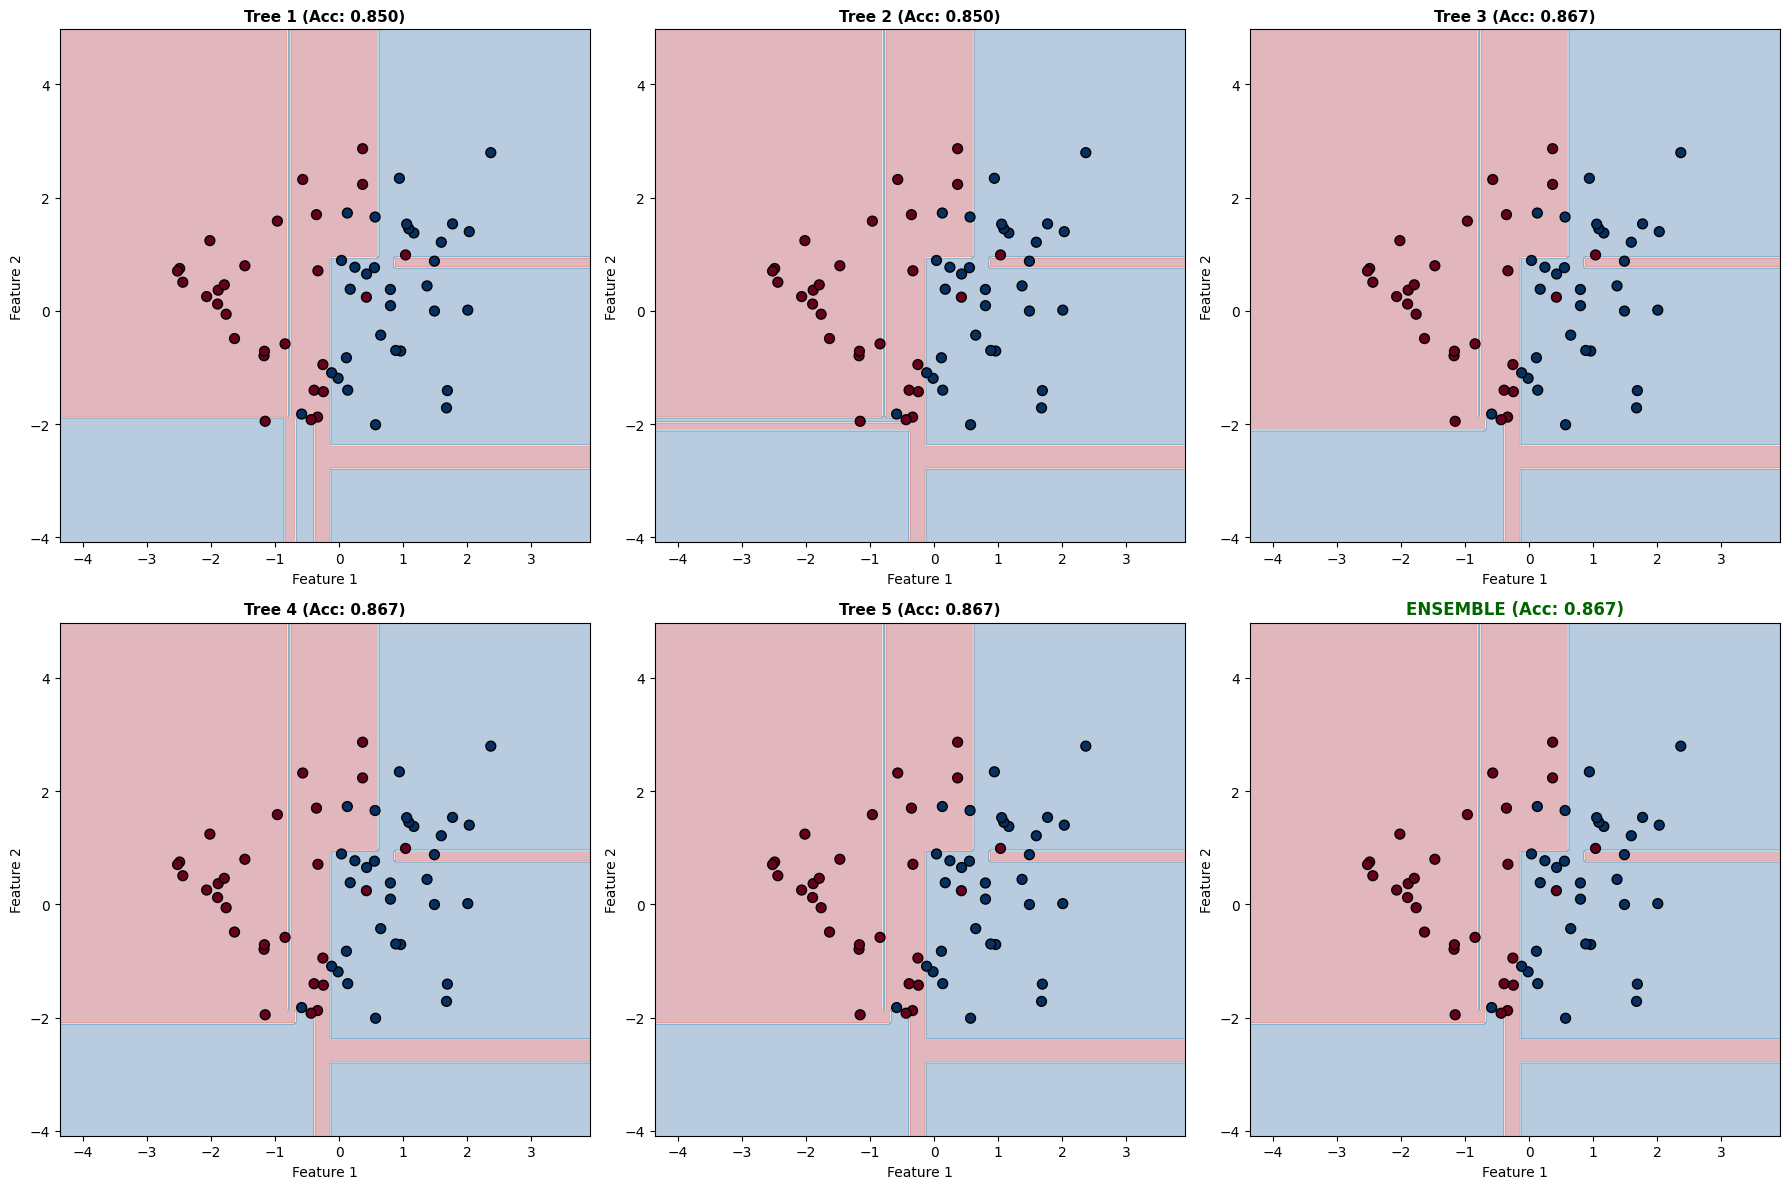

Notice: The ensemble boundary is smoother and more robust!


In [5]:
# Visualize how ensemble combines predictions
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

# Plot each tree's decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

for i in range(n_trees):
    Z = trees[i].predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axes[i].contourf(xx, yy, Z, alpha=0.3, cmap='RdBu')
    axes[i].scatter(X_test[:, 0], X_test[:, 1], c=y_test, 
                   cmap='RdBu', edgecolors='black', s=50)
    
    acc = accuracy_score(y_test, predictions[i])
    axes[i].set_title(f'Tree {i+1} (Acc: {acc:.3f})', 
                     fontsize=11, fontweight='bold')
    axes[i].set_xlabel('Feature 1')
    axes[i].set_ylabel('Feature 2')

# Plot ensemble decision boundary
ensemble_votes = np.zeros((len(xx.ravel()), 2))
for tree in trees:
    pred = tree.predict(np.c_[xx.ravel(), yy.ravel()])
    for j, p in enumerate(pred):
        ensemble_votes[j, p] += 1

Z_ensemble = np.argmax(ensemble_votes, axis=1).reshape(xx.shape)

axes[5].contourf(xx, yy, Z_ensemble, alpha=0.3, cmap='RdBu')
axes[5].scatter(X_test[:, 0], X_test[:, 1], c=y_test, 
               cmap='RdBu', edgecolors='black', s=50)
axes[5].set_title(f'ENSEMBLE (Acc: {ensemble_accuracy:.3f})', 
                 fontsize=12, fontweight='bold', color='darkgreen')
axes[5].set_xlabel('Feature 1')
axes[5].set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

print("Notice: The ensemble boundary is smoother and more robust!")

## 3. Bootstrap Aggregating (Bagging)

To make trees different from each other, Random Forests use **Bootstrap Sampling**:

1. **Bootstrap**: Randomly sample training data WITH replacement
2. **Train**: Build a tree on this bootstrap sample
3. **Repeat**: Create many trees (typically 100-500)
4. **Aggregate**: Combine predictions (voting for classification, averaging for regression)

**Key idea**: Each tree sees a slightly different version of the data!

Original indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

3 Bootstrap samples (sampling WITH replacement):

Bootstrap 1: [2 6 7 3 1 9 2 0 7 2]
  Unique samples: 7/10
  Missing samples: [4 5 8]

Bootstrap 2: [9 6 9 4 9 4 6 8 4 0]
  Unique samples: 5/10
  Missing samples: [1 2 3 5 7]

Bootstrap 3: [9 9 0 1 5 8 7 4 0 6]
  Unique samples: 8/10
  Missing samples: [2 3]


On average, a bootstrap sample contains 6.5 unique samples
This means ~34.9% of samples are missing!


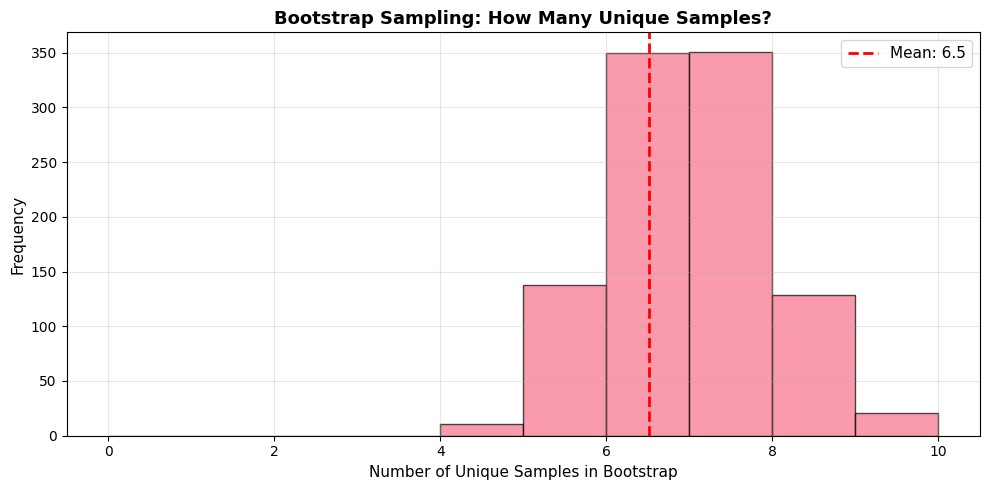


Key Insight: Each tree trains on ~63% unique samples
This creates diversity among trees!


In [6]:
# Demonstrate bootstrap sampling
print("Original indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]\n")

n_samples = 10
original_indices = np.arange(n_samples)

print("3 Bootstrap samples (sampling WITH replacement):\n")
for i in range(3):
    bootstrap_indices = np.random.choice(original_indices, size=n_samples, replace=True)
    unique_indices = np.unique(bootstrap_indices)
    missing_indices = np.setdiff1d(original_indices, unique_indices)
    
    print(f"Bootstrap {i+1}: {bootstrap_indices}")
    print(f"  Unique samples: {len(unique_indices)}/10")
    print(f"  Missing samples: {missing_indices}")
    print()

# Simulate many bootstrap samples
n_bootstraps = 1000
unique_counts = []

for _ in range(n_bootstraps):
    bootstrap = np.random.choice(original_indices, size=n_samples, replace=True)
    unique_counts.append(len(np.unique(bootstrap)))

print(f"\nOn average, a bootstrap sample contains {np.mean(unique_counts):.1f} unique samples")
print(f"This means ~{(1 - np.mean(unique_counts)/n_samples)*100:.1f}% of samples are missing!")

# Visualize
plt.figure(figsize=(10, 5))
plt.hist(unique_counts, bins=range(n_samples+1), edgecolor='black', alpha=0.7)
plt.axvline(np.mean(unique_counts), color='red', linestyle='--', 
           linewidth=2, label=f'Mean: {np.mean(unique_counts):.1f}')
plt.xlabel('Number of Unique Samples in Bootstrap', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Bootstrap Sampling: How Many Unique Samples?', fontsize=13, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nKey Insight: Each tree trains on ~63% unique samples")
print("This creates diversity among trees!")

## 4. Random Feature Selection

Random Forests add another layer of randomness:

**At each split**, only consider a random subset of features

- Typical choice: $\sqrt{n_{features}}$ for classification
- This decorrelates the trees (makes them more different)
- Result: Even more diversity!

**Two sources of randomness**:
1. Bootstrap sampling (different data)
2. Random feature selection (different features)

In [7]:
# Demonstrate effect of max_features
print("Effect of max_features (random feature selection)\n")

# Create dataset with more features
X_many, y_many = make_classification(
    n_samples=500,
    n_features=20,
    n_informative=15,
    n_redundant=5,
    n_classes=2,
    random_state=42
)

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_many, y_many, test_size=0.3, random_state=42
)

print(f"Dataset: {X_many.shape[0]} samples, {X_many.shape[1]} features")
print(f"sqrt({X_many.shape[1]}) = {int(np.sqrt(X_many.shape[1]))}\n")

# Compare different max_features
max_features_options = [1, 'sqrt', 'log2', None]  # None = all features

for max_feat in max_features_options:
    rf = RandomForestClassifier(
        n_estimators=100,
        max_features=max_feat,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train_m, y_train_m)
    
    train_acc = rf.score(X_train_m, y_train_m)
    test_acc = rf.score(X_test_m, y_test_m)
    
    if max_feat == 'sqrt':
        n_features_str = f"{int(np.sqrt(X_many.shape[1]))} (sqrt)"
    elif max_feat == 'log2':
        n_features_str = f"{int(np.log2(X_many.shape[1]))} (log2)"
    elif max_feat is None:
        n_features_str = f"{X_many.shape[1]} (all)"
    else:
        n_features_str = str(max_feat)
    
    print(f"max_features={n_features_str:15s}: Train={train_acc:.3f}, Test={test_acc:.3f}")

print("\nNote: 'sqrt' (default) usually works best for classification!")

Effect of max_features (random feature selection)

Dataset: 500 samples, 20 features
sqrt(20) = 4

max_features=1              : Train=1.000, Test=0.913
max_features=4 (sqrt)       : Train=1.000, Test=0.880
max_features=4 (log2)       : Train=1.000, Test=0.880
max_features=20 (all)       : Train=1.000, Test=0.840

Note: 'sqrt' (default) usually works best for classification!


## 5. Random Forests in Action: Breast Cancer Dataset

In [8]:
# Load breast cancer dataset
cancer = load_breast_cancer()
X_cancer, y_cancer = cancer.data, cancer.target

# Create DataFrame
df_cancer = pd.DataFrame(X_cancer, columns=cancer.feature_names)
df_cancer['target'] = y_cancer

print("Breast Cancer Wisconsin Dataset")
print("="*60)
print(f"Samples: {X_cancer.shape[0]}")
print(f"Features: {X_cancer.shape[1]}")
print(f"Classes: {cancer.target_names}")
print(f"\nClass distribution:")
print(f"  Malignant: {(y_cancer == 0).sum()}")
print(f"  Benign: {(y_cancer == 1).sum()}")

print("\nFirst few samples:")
print(df_cancer.head())

# Split data
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_cancer, y_cancer, test_size=0.3, random_state=42, stratify=y_cancer
)

print(f"\nTraining set: {X_train_c.shape}")
print(f"Test set: {X_test_c.shape}")

Breast Cancer Wisconsin Dataset
Samples: 569
Features: 30
Classes: ['malignant' 'benign']

Class distribution:
  Malignant: 212
  Benign: 357

First few samples:
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4     

### 5.1 Compare Single Tree vs Random Forest

In [9]:
# Train single decision tree
print("Training Single Decision Tree...")
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train_c, y_train_c)

tree_train_acc = tree.score(X_train_c, y_train_c)
tree_test_acc = tree.score(X_test_c, y_test_c)

print(f"  Train Accuracy: {tree_train_acc:.3f}")
print(f"  Test Accuracy: {tree_test_acc:.3f}")

# Train Random Forest
print("\nTraining Random Forest (100 trees)...")
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_c, y_train_c)

rf_train_acc = rf.score(X_train_c, y_train_c)
rf_test_acc = rf.score(X_test_c, y_test_c)

print(f"  Train Accuracy: {rf_train_acc:.3f}")
print(f"  Test Accuracy: {rf_test_acc:.3f}")

print("\n" + "="*60)
print("COMPARISON:")
print("="*60)
print(f"Single Tree - Train: {tree_train_acc:.3f}, Test: {tree_test_acc:.3f}")
print(f"Random Forest - Train: {rf_train_acc:.3f}, Test: {rf_test_acc:.3f}")
print(f"\nImprovement: {(rf_test_acc - tree_test_acc)*100:.1f} percentage points!")
print(f"Overfitting (Single Tree): {(tree_train_acc - tree_test_acc)*100:.1f} pp")
print(f"Overfitting (Random Forest): {(rf_train_acc - rf_test_acc)*100:.1f} pp")

Training Single Decision Tree...
  Train Accuracy: 1.000
  Test Accuracy: 0.918

Training Random Forest (100 trees)...
  Train Accuracy: 1.000
  Test Accuracy: 0.936

COMPARISON:
Single Tree - Train: 1.000, Test: 0.918
Random Forest - Train: 1.000, Test: 0.936

Improvement: 1.8 percentage points!
Overfitting (Single Tree): 8.2 pp
Overfitting (Random Forest): 6.4 pp


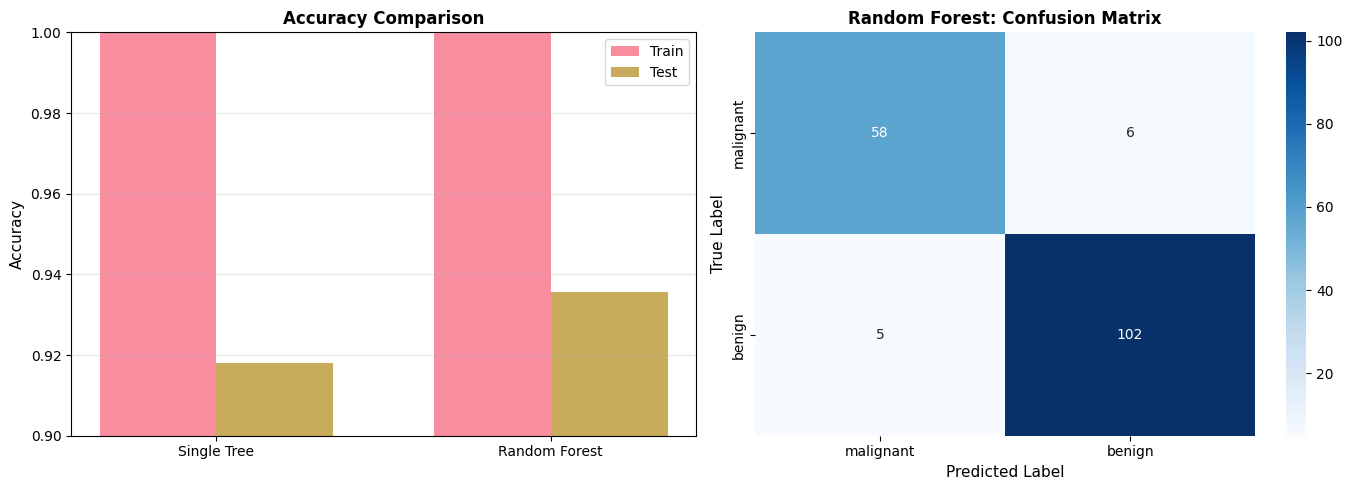


Random Forest Classification Report:
              precision    recall  f1-score   support

   malignant       0.92      0.91      0.91        64
      benign       0.94      0.95      0.95       107

    accuracy                           0.94       171
   macro avg       0.93      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171



In [10]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
models = ['Single Tree', 'Random Forest']
train_scores = [tree_train_acc, rf_train_acc]
test_scores = [tree_test_acc, rf_test_acc]

x = np.arange(len(models))
width = 0.35

axes[0].bar(x - width/2, train_scores, width, label='Train', alpha=0.8)
axes[0].bar(x + width/2, test_scores, width, label='Test', alpha=0.8)
axes[0].set_ylabel('Accuracy', fontsize=11)
axes[0].set_title('Accuracy Comparison', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0.9, 1.0])

# Confusion matrices
y_pred_tree = tree.predict(X_test_c)
y_pred_rf = rf.predict(X_test_c)

cm_rf = confusion_matrix(y_test_c, y_pred_rf)

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[1],
           xticklabels=cancer.target_names,
           yticklabels=cancer.target_names)
axes[1].set_ylabel('True Label', fontsize=11)
axes[1].set_xlabel('Predicted Label', fontsize=11)
axes[1].set_title('Random Forest: Confusion Matrix', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Detailed classification report
print("\nRandom Forest Classification Report:")
print("="*60)
print(classification_report(y_test_c, y_pred_rf, target_names=cancer.target_names))

### 5.2 Effect of Number of Trees (n_estimators)

Testing different numbers of trees:

n_estimators=  1: Train=0.977, Test=0.912
n_estimators=  5: Train=0.990, Test=0.936
n_estimators= 10: Train=1.000, Test=0.930
n_estimators= 20: Train=1.000, Test=0.930
n_estimators= 50: Train=1.000, Test=0.924
n_estimators=100: Train=1.000, Test=0.936
n_estimators=200: Train=1.000, Test=0.942
n_estimators=500: Train=1.000, Test=0.947


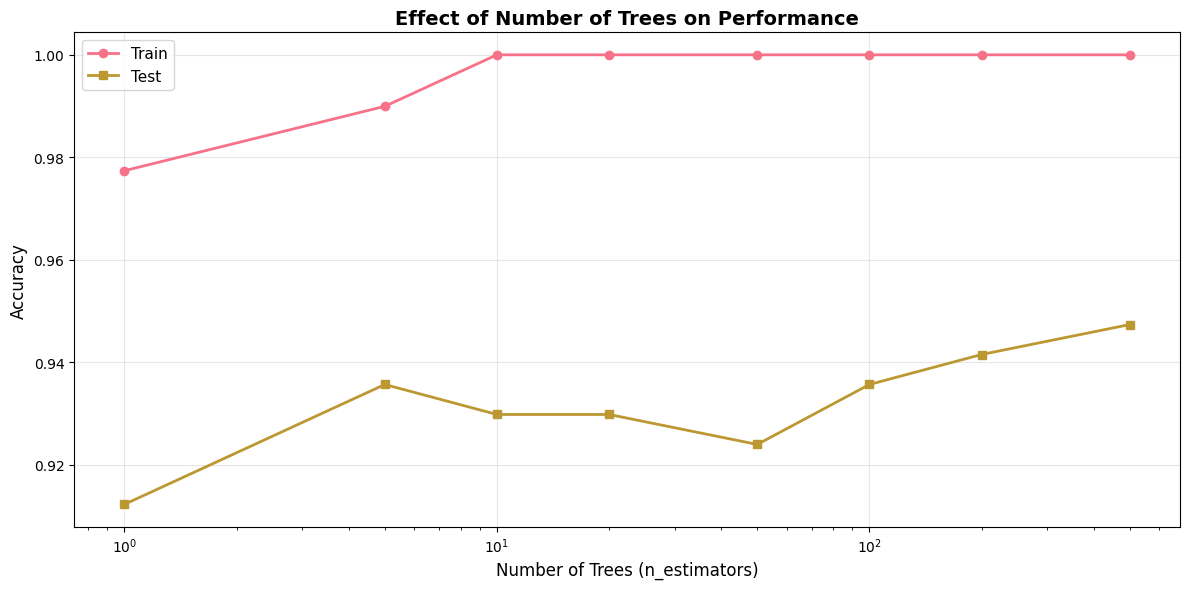


Key Insight:
- Performance improves rapidly with more trees
- Improvement plateaus after ~100 trees
- More trees = more computation but no overfitting!
- Common choice: 100-500 trees


In [20]:
# Test different numbers of trees
n_estimators_range = [1, 5, 10, 20, 50, 100, 200, 500]
train_scores = []
test_scores = []

print("Testing different numbers of trees:\n")
for n_est in n_estimators_range:
    rf = RandomForestClassifier(n_estimators=n_est, random_state=42, n_jobs=-1)
    rf.fit(X_train_c, y_train_c)
    
    train_acc = rf.score(X_train_c, y_train_c)
    test_acc = rf.score(X_test_c, y_test_c)
    
    train_scores.append(train_acc)
    test_scores.append(test_acc)
    
    print(f"n_estimators={n_est:3d}: Train={train_acc:.3f}, Test={test_acc:.3f}")

# Visualize
plt.figure(figsize=(12, 6))
plt.plot(n_estimators_range, train_scores, 'o-', label='Train', linewidth=2)
plt.plot(n_estimators_range, test_scores, 's-', label='Test', linewidth=2)
plt.xlabel('Number of Trees (n_estimators)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Effect of Number of Trees on Performance', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xscale('log')
plt.tight_layout()
plt.show()

print("\nKey Insight:")
print("- Performance improves rapidly with more trees")
print("- Improvement plateaus after ~100 trees")
print("- More trees = more computation but no overfitting!")
print("- Common choice: 100-500 trees")

## 6. Out-of-Bag (OOB) Error

Remember: Each tree is trained on a bootstrap sample (~63% of data)

The remaining ~37% are called **Out-of-Bag (OOB) samples**

**OOB Error**: Use OOB samples as a validation set (free cross-validation!)

- For each sample, average predictions from trees that didn't see it
- No need for separate validation set
- Good estimate of test performance

Random Forest with OOB Error Estimation:

Training Accuracy: 1.000
OOB Accuracy: 0.957 (free validation!)
Test Accuracy: 0.936

OOB vs Test difference: 0.022

OOB score is close to test score - good estimate!


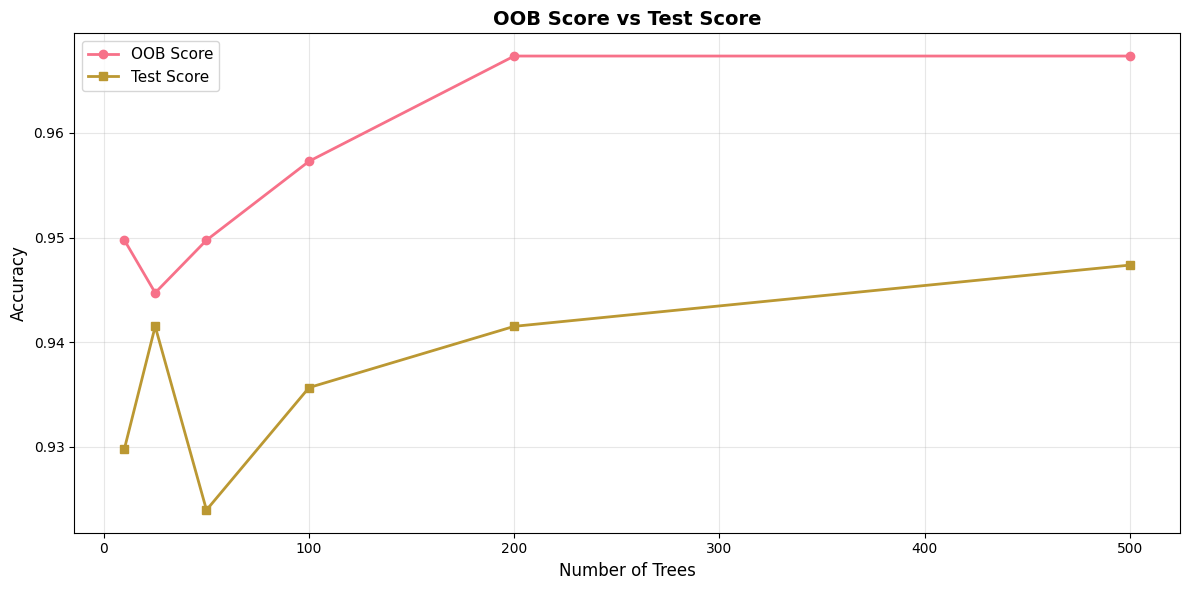


Key Insight: OOB score closely tracks test performance!
You can use OOB score for model selection without a validation set.


In [21]:
# Train Random Forest with OOB score
print("Random Forest with OOB Error Estimation:\n")

rf_oob = RandomForestClassifier(
    n_estimators=100,
    oob_score=True,  # Enable OOB error calculation
    random_state=42,
    n_jobs=-1
)

rf_oob.fit(X_train_c, y_train_c)

train_acc = rf_oob.score(X_train_c, y_train_c)
oob_acc = rf_oob.oob_score_
test_acc = rf_oob.score(X_test_c, y_test_c)

print(f"Training Accuracy: {train_acc:.3f}")
print(f"OOB Accuracy: {oob_acc:.3f} (free validation!)")
print(f"Test Accuracy: {test_acc:.3f}")
print(f"\nOOB vs Test difference: {abs(oob_acc - test_acc):.3f}")
print("\nOOB score is close to test score - good estimate!")

# Compare OOB scores for different n_estimators
n_estimators_range = [10, 25, 50, 100, 200, 500]
oob_scores = []
test_scores = []

for n_est in n_estimators_range:
    rf = RandomForestClassifier(
        n_estimators=n_est,
        oob_score=True,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train_c, y_train_c)
    oob_scores.append(rf.oob_score_)
    test_scores.append(rf.score(X_test_c, y_test_c))

# Visualize
plt.figure(figsize=(12, 6))
plt.plot(n_estimators_range, oob_scores, 'o-', label='OOB Score', linewidth=2)
plt.plot(n_estimators_range, test_scores, 's-', label='Test Score', linewidth=2)
plt.xlabel('Number of Trees', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('OOB Score vs Test Score', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nKey Insight: OOB score closely tracks test performance!")
print("You can use OOB score for model selection without a validation set.")

## 7. Hyperparameter Tuning for Random Forests

Key hyperparameters:
1. **n_estimators**: Number of trees (100-500 is typical)
2. **max_features**: Features per split ('sqrt' for classification)
3. **max_depth**: Maximum tree depth (None = unlimited)
4. **min_samples_split**: Minimum samples to split a node
5. **min_samples_leaf**: Minimum samples in leaf node

In [22]:
# Grid search for best hyperparameters
print("Testing different hyperparameter combinations:\n")

param_combinations = [
    {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2},
    {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 2},
    {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2},
    {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 5},
    {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 10},
]

results = []
for i, params in enumerate(param_combinations):
    rf = RandomForestClassifier(**params, random_state=42, n_jobs=-1)
    
    # Cross-validation
    cv_scores = cross_val_score(rf, X_train_c, y_train_c, cv=5)
    
    # Train and test
    rf.fit(X_train_c, y_train_c)
    test_score = rf.score(X_test_c, y_test_c)
    
    results.append({
        'config': i+1,
        'n_estimators': params['n_estimators'],
        'max_depth': params['max_depth'],
        'min_samples_split': params['min_samples_split'],
        'cv_score': cv_scores.mean(),
        'test_score': test_score
    })
    
    print(f"Config {i+1}: {params}")
    print(f"  CV Score: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
    print(f"  Test Score: {test_score:.3f}\n")

# Find best configuration
results_df = pd.DataFrame(results)
best_idx = results_df['cv_score'].idxmax()
best_config = results_df.loc[best_idx]

print("="*60)
print("BEST CONFIGURATION:")
print("="*60)
print(f"n_estimators: {int(best_config['n_estimators'])}")
print(f"max_depth: {best_config['max_depth']}")
print(f"min_samples_split: {int(best_config['min_samples_split'])}")
print(f"CV Score: {best_config['cv_score']:.3f}")
print(f"Test Score: {best_config['test_score']:.3f}")

Testing different hyperparameter combinations:

Config 1: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2}
  CV Score: 0.973 ± 0.033
  Test Score: 0.936

Config 2: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 2}
  CV Score: 0.967 ± 0.032
  Test Score: 0.942

Config 3: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2}
  CV Score: 0.970 ± 0.031
  Test Score: 0.936

Config 4: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 5}
  CV Score: 0.965 ± 0.030
  Test Score: 0.947

Config 5: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 10}
  CV Score: 0.970 ± 0.031
  Test Score: 0.930

BEST CONFIGURATION:
n_estimators: 100
max_depth: nan
min_samples_split: 2
CV Score: 0.973
Test Score: 0.936


## 8. Visualizing Random Forest Predictions

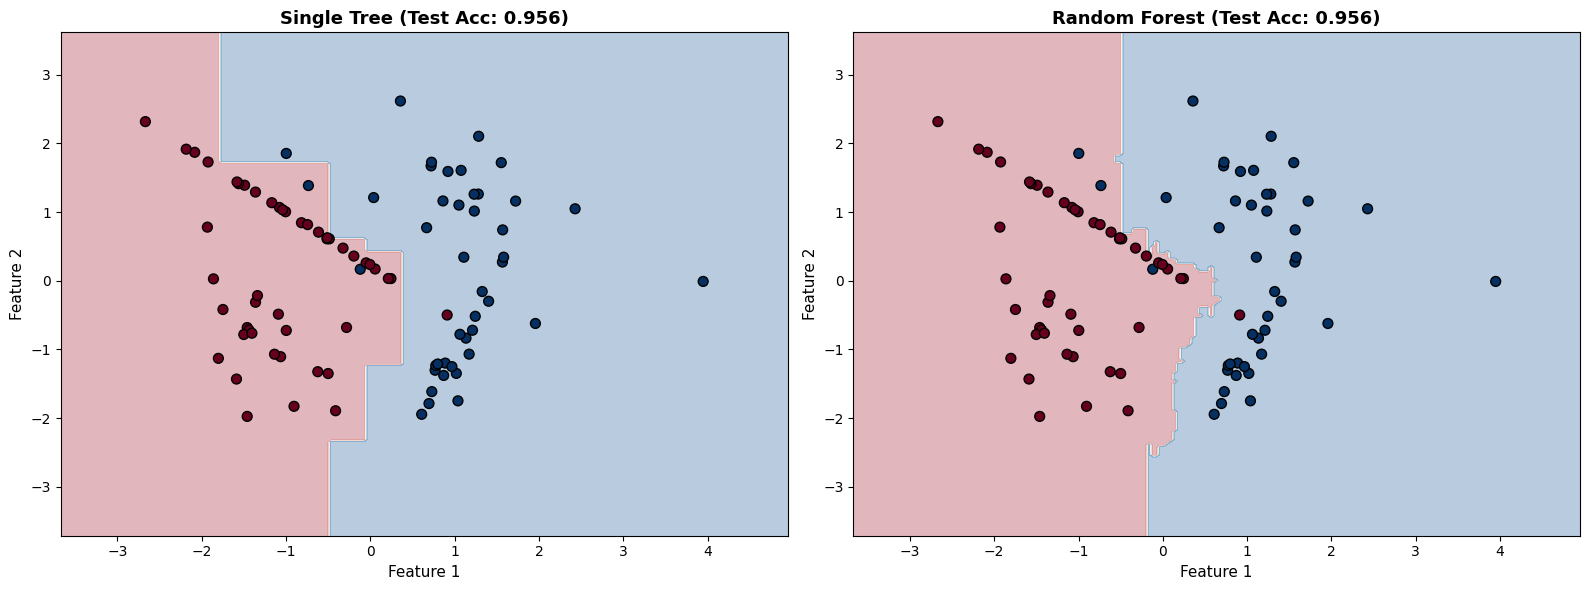

Notice:
- Single tree: Sharp, jagged boundaries (overfitting)
- Random Forest: Smoother boundaries (better generalization)


In [23]:
# Create simple 2D dataset for visualization
X_vis, y_vis = make_classification(
    n_samples=300,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=2,
    random_state=42
)

X_train_v, X_test_v, y_train_v, y_test_v = train_test_split(
    X_vis, y_vis, test_size=0.3, random_state=42
)

# Train models
tree_vis = DecisionTreeClassifier(max_depth=10, random_state=42)
tree_vis.fit(X_train_v, y_train_v)

rf_vis = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_vis.fit(X_train_v, y_train_v)

# Create meshgrid
x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Plot decision boundaries
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Single tree
Z_tree = tree_vis.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
axes[0].contourf(xx, yy, Z_tree, alpha=0.3, cmap='RdBu')
axes[0].scatter(X_test_v[:, 0], X_test_v[:, 1], c=y_test_v, 
               cmap='RdBu', edgecolors='black', s=50)
axes[0].set_title(f'Single Tree (Test Acc: {tree_vis.score(X_test_v, y_test_v):.3f})',
                 fontsize=13, fontweight='bold')
axes[0].set_xlabel('Feature 1', fontsize=11)
axes[0].set_ylabel('Feature 2', fontsize=11)

# Random Forest
Z_rf = rf_vis.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
axes[1].contourf(xx, yy, Z_rf, alpha=0.3, cmap='RdBu')
axes[1].scatter(X_test_v[:, 0], X_test_v[:, 1], c=y_test_v, 
               cmap='RdBu', edgecolors='black', s=50)
axes[1].set_title(f'Random Forest (Test Acc: {rf_vis.score(X_test_v, y_test_v):.3f})',
                 fontsize=13, fontweight='bold')
axes[1].set_xlabel('Feature 1', fontsize=11)
axes[1].set_ylabel('Feature 2', fontsize=11)

plt.tight_layout()
plt.show()

print("Notice:")
print("- Single tree: Sharp, jagged boundaries (overfitting)")
print("- Random Forest: Smoother boundaries (better generalization)")

## 9. Practice Exercises

### Exercise 1: Effect of n_estimators

Train Random Forests with 1, 10, 50, 100, 200 trees.
Plot how the test accuracy improves with more trees.

In [ ]:
# Your code here
n_trees = [1, 10, 50, 100, 200]
accuracies = []

for n in n_trees:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train_c, y_train_c)
    acc = rf.score(X_test_c, y_test_c)
    accuracies.append(acc)

plt.figure(figsize=(10, 6))
plt.plot(n_trees, accuracies, 'o-', linewidth=2, markersize=8)
plt.xlabel('Number of Trees', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('Accuracy vs Number of Trees', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Exercise 2: Compare with Cross-Validation

Compare single tree vs Random Forest using 5-fold cross-validation.
Which has lower variance in performance?

In [ ]:
# Your code here
tree_cv = cross_val_score(DecisionTreeClassifier(random_state=42), 
                          X_cancer, y_cancer, cv=5)
rf_cv = cross_val_score(RandomForestClassifier(n_estimators=100, random_state=42), 
                        X_cancer, y_cancer, cv=5)

print("Cross-Validation Results (5-fold):\n")
print(f"Single Tree:   {tree_cv.mean():.3f} ± {tree_cv.std():.3f}")
print(f"Random Forest: {rf_cv.mean():.3f} ± {rf_cv.std():.3f}")
print(f"\nRandom Forest has {tree_cv.std() / rf_cv.std():.1f}x lower variance!")

# Visualize
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), tree_cv, 'o-', label='Single Tree', linewidth=2)
plt.plot(range(1, 6), rf_cv, 's-', label='Random Forest', linewidth=2)
plt.xlabel('Fold', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Cross-Validation Performance', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Exercise 3: Optimal max_depth

Find the optimal max_depth for a Random Forest with 100 trees.
Test depths from 5 to 30.

In [ ]:
# Your code here
depths = range(5, 31, 5)
train_scores = []
test_scores = []

for depth in depths:
    rf = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=42)
    rf.fit(X_train_c, y_train_c)
    train_scores.append(rf.score(X_train_c, y_train_c))
    test_scores.append(rf.score(X_test_c, y_test_c))

best_depth = list(depths)[np.argmax(test_scores)]

plt.figure(figsize=(10, 6))
plt.plot(depths, train_scores, 'o-', label='Train', linewidth=2)
plt.plot(depths, test_scores, 's-', label='Test', linewidth=2)
plt.axvline(best_depth, color='red', linestyle='--', 
           label=f'Best depth: {best_depth}')
plt.xlabel('max_depth', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Finding Optimal max_depth', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Optimal max_depth: {best_depth}")
print(f"Test accuracy: {max(test_scores):.3f}")

## Summary

### Key Takeaways:

1. **Ensemble Learning**: Combining many models is better than using one
   - "Wisdom of crowds" principle
   - Reduces variance and overfitting

2. **Random Forests = Bagging + Random Features**:
   - **Bootstrap sampling**: Each tree sees different data
   - **Random features**: Each split considers random subset of features
   - **Voting**: Combine predictions from all trees

3. **Advantages over single trees**:
   - More accurate
   - More stable (lower variance)
   - Less prone to overfitting
   - Handles high-dimensional data well

4. **Key hyperparameters**:
   - **n_estimators**: 100-500 (more is better, but slower)
   - **max_features**: 'sqrt' for classification (default)
   - **max_depth**: None or tune with cross-validation
   - **min_samples_split**: 2-10

5. **Out-of-Bag (OOB) error**: Free validation estimate

### Quick Reference:

```python
from sklearn.ensemble import RandomForestClassifier

# Create Random Forest
rf = RandomForestClassifier(
    n_estimators=100,        # Number of trees
    max_features='sqrt',     # Features per split
    max_depth=None,          # No depth limit
    min_samples_split=2,     # Min samples to split
    oob_score=True,          # Enable OOB error
    random_state=42,         # Reproducibility
    n_jobs=-1                # Use all CPU cores
)

# Train
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Check OOB score
print(f"OOB Score: {rf.oob_score_:.3f}")
```

### When to use Random Forests:
- Default choice for many classification/regression tasks
- Works well "out of the box"
- Good with high-dimensional data
- Interpretable (feature importance)
- Robust to outliers and noise

### Limitations:
- Can be slow with many trees
- Larger model size (memory)
- Less interpretable than single tree
- Not as accurate as gradient boosting (next notebook!)

### Next Steps:

In the next notebook, we'll learn about **Gradient Boosting, XGBoost, and LightGBM** - even more powerful ensemble methods that often win machine learning competitions!